# Imports & Load Data

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# Load dataset

In [135]:
df = pd.read_csv("../dataset/burnout_dataset.csv")

print(df.head())
print(df["risk_level"].value_counts())

   q1  q2  q3  q4  q5  q6  q7  q8  q9  q10  q11  q12  burnout_score  \
0   1   1   2   3   1   3   3   3   2    3    2    3           56.2   
1   2   3   1   2   3   2   3   2   4    2    4    4           66.7   
2   1   2   2   2   1   1   2   1   2    2    3    2           43.8   
3   2   2   2   2   2   1   3   3   2    2    3    3           56.2   
4   1   2   2   0   1   2   1   2   3    2    1    2           39.6   

   risk_level  true_risk  latent_burnout  
0           1          1        0.517770  
1           2          2        0.666466  
2           1          1        0.538020  
3           1          1        0.561059  
4           0          0        0.255979  
risk_level
1    447
0    310
2    243
Name: count, dtype: int64


# Define Features (X) and Target (y)

In [136]:
# Features = 12 questions
feature_cols = [f"q{i}" for i in range(1, 13)]
X = df[feature_cols]

# Target = burnout risk level
y = df["risk_level"]

# Train/Test Split

In [137]:
feature_cols = [f"q{i}" for i in range(1, 13)]
X = df[feature_cols]
y = df["risk_level"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [138]:
print("Train:", y_train.value_counts(normalize=True).round(2))
print("Test:", y_test.value_counts(normalize=True).round(2))

Train: risk_level
1    0.45
0    0.31
2    0.24
Name: proportion, dtype: float64
Test: risk_level
1    0.44
0    0.31
2    0.24
Name: proportion, dtype: float64


# Define Pipeline + Candidate Algorithms

In [139]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())   # placeholder
])

# Define Param Grid for GridSearchCV

In [140]:
param_grid = [
    {
        "clf": [LogisticRegression(max_iter=1000, multi_class="auto")],
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__class_weight": [None, "balanced"]
    },
    {
        "clf": [SVC()],
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ["scale", "auto"],
        "clf__class_weight": [None, "balanced"]
    },
    {
        "clf": [RandomForestClassifier()],
        "clf__n_estimators": [100, 300],
        "clf__max_depth": [None, 5, 10],
        "clf__min_samples_split": [2, 5],
        "clf__class_weight": [None, "balanced"]
    }
]

# Run GridSearchCV to Find Best Algo + Params

In [141]:
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    verbose=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 44 candidates, totalling 220 fits


c:\anaconda\envs\burnout-env\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,estimator,Pipeline(step...egression())])
,param_grid,"[{'clf': [LogisticRegre..._class='auto')], 'clf__C': [0.01, 0.1, ...], 'clf__class_weight': [None, 'balanced'], 'clf__penalty': ['l2']}, {'clf': [SVC()], 'clf__C': [0.1, 1, ...], 'clf__class_weight': [None, 'balanced'], 'clf__gamma': ['scale', 'auto']}, ...]"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [142]:
results = pd.DataFrame(grid_search.cv_results_)
results["model"] = results["param_clf"].apply(lambda est: type(est).__name__)

cols = ["model", "params", "mean_test_score", "std_test_score", "rank_test_score"]
comparison = results[cols].sort_values("rank_test_score")
comparison.head(10)

,model,params,mean_test_score,std_test_score,rank_test_score
6,LogisticRegression,"{'clf': LogisticRegression(max_iter=1000, mult...",0.84000,0.021866,1
2,LogisticRegression,"{'clf': LogisticRegression(max_iter=1000, mult...",0.83875,0.019526,2
3,LogisticRegression,"{'clf': LogisticRegression(max_iter=1000, mult...",0.83875,0.007289,2
4,LogisticRegression,"{'clf': LogisticRegression(max_iter=1000, mult...",0.83875,0.019922,2
7,LogisticRegression,"{'clf': LogisticRegression(max_iter=1000, mult...",0.83875,0.011456,2
8,SVC,"{'clf': SVC(), 'clf__C': 0.1, 'clf__class_weig...",0.83875,0.016008,2
9,SVC,"{'clf': SVC(), 'clf__C': 0.1, 'clf__class_weig...",0.83875,0.016008,2
0,LogisticRegression,"{'clf': LogisticRegression(max_iter=1000, mult...",0.83625,0.010753,8
5,LogisticRegression,"{'clf': LogisticRegression(max_iter=1000, mult...",0.83625,0.009186,8
10,SVC,"{'clf': SVC(), 'clf__C': 0.1, 'clf__class_weig...",0.83625,0.023184,10


In [143]:
print("Best Model:", grid_search.best_estimator_)
print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)
comparison.to_csv("../results/model_comparison.csv", index=False)

Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=10, max_iter=1000, multi_class='auto'))])
Best Params: {'clf': LogisticRegression(max_iter=1000, multi_class='auto'), 'clf__C': 10, 'clf__class_weight': None, 'clf__penalty': 'l2'}
Best CV Score: 0.8399999999999999


In [144]:
import pandas as pd

results = pd.DataFrame(grid_search.cv_results_)

# See which model types were tested
models_tested = results["param_clf"].apply(lambda est: type(est).__name__).unique()
print("Models tested:", models_tested)

Models tested: ['LogisticRegression' 'SVC' 'RandomForestClassifier']


# Compare all algorithms and scores

In [145]:
results = pd.DataFrame(grid_search.cv_results_)

results["model"] = results["param_clf"].apply(lambda est: type(est).__name__)

cols = ["model", "params", "mean_test_score", "std_test_score", "rank_test_score"]
comparison = results[cols].sort_values("rank_test_score")

# Show top 10 configurations
comparison.head(10)

,model,params,mean_test_score,std_test_score,rank_test_score
6,LogisticRegression,"{'clf': LogisticRegression(max_iter=1000, mult...",0.84000,0.021866,1
2,LogisticRegression,"{'clf': LogisticRegression(max_iter=1000, mult...",0.83875,0.019526,2
3,LogisticRegression,"{'clf': LogisticRegression(max_iter=1000, mult...",0.83875,0.007289,2
4,LogisticRegression,"{'clf': LogisticRegression(max_iter=1000, mult...",0.83875,0.019922,2
7,LogisticRegression,"{'clf': LogisticRegression(max_iter=1000, mult...",0.83875,0.011456,2
8,SVC,"{'clf': SVC(), 'clf__C': 0.1, 'clf__class_weig...",0.83875,0.016008,2
9,SVC,"{'clf': SVC(), 'clf__C': 0.1, 'clf__class_weig...",0.83875,0.016008,2
0,LogisticRegression,"{'clf': LogisticRegression(max_iter=1000, mult...",0.83625,0.010753,8
5,LogisticRegression,"{'clf': LogisticRegression(max_iter=1000, mult...",0.83625,0.009186,8
10,SVC,"{'clf': SVC(), 'clf__C': 0.1, 'clf__class_weig...",0.83625,0.023184,10


In [146]:
print("Best Model:", grid_search.best_estimator_)
print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=10, max_iter=1000, multi_class='auto'))])
Best Params: {'clf': LogisticRegression(max_iter=1000, multi_class='auto'), 'clf__C': 10, 'clf__class_weight': None, 'clf__penalty': 'l2'}
Best CV Score: 0.8399999999999999


# Evaluate the Best Model on Test Set

In [147]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.86      0.79      0.82        62
           1       0.75      0.85      0.80        89
           2       0.88      0.76      0.81        49

    accuracy                           0.81       200
   macro avg       0.83      0.80      0.81       200
weighted avg       0.82      0.81      0.81       200



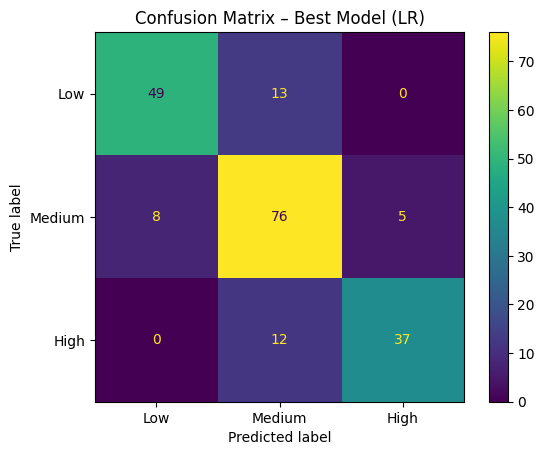

In [148]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Low", "Medium", "High"])
disp.plot()
plt.title("Confusion Matrix – Best Model (LR)")
plt.show()

In [149]:
misclassified = X_test[y_test != y_pred]
mis_labels = y_test[y_test != y_pred]

print("Number of misclassified samples:", len(misclassified))

Number of misclassified samples: 38


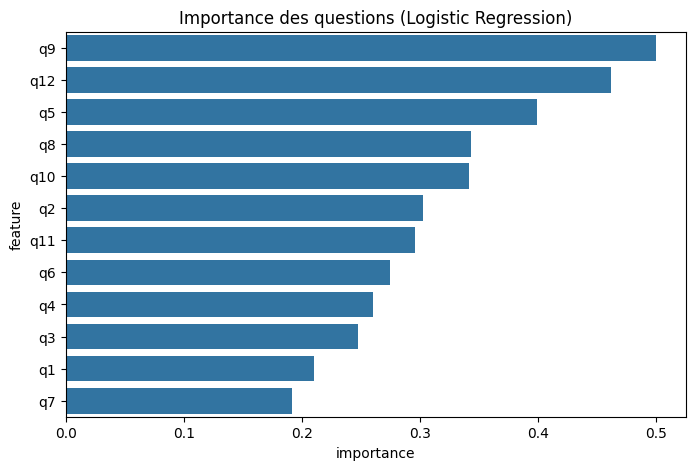

In [150]:
coef = best_model.named_steps["clf"].coef_
importance = np.mean(np.abs(coef), axis=0)

imp_df = pd.DataFrame({"feature": X.columns, "importance": importance})
imp_df = imp_df.sort_values("importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=imp_df, x="importance", y="feature")
plt.title("Importance des questions (Logistic Regression)")
plt.show()

# Save Model

In [151]:
import joblib
joblib.dump(best_model, "../models/burnout_best_model.pkl")
print("Model saved!")

Model saved!
